# ML PID Sample Code
***
This code shows how to use an MLP in TensorFlow to conduct particle identification for the SoLID beam test.


By: Darren Upton <br>
Modeled on Code By: Kishan Rajput

In [1]:
#Import packages
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
import pickle
import seaborn as sns

#Stuff for ML
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import random
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

from keras import backend as K

from matplotlib.colors import LogNorm


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pxh89t_0 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


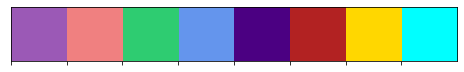

In [2]:
#Get Custom Color Palette
best_colors = ["#9b59b6",
               "lightcoral",
               "#2ecc71","cornflowerblue","indigo",#"darkorange",
               "firebrick","gold",
               "cyan"#"magenta"
              ]
sns.set_palette(sns.color_palette(best_colors))
sns.palplot(sns.color_palette(best_colors))

## Import Simulation
***
This is the pencil simulation for the simple case of events passing through the center of the detector set-up. As for events, the sample of the pencil simulation contains, $\pi^-$, $e^-$, & $\gamma$ (pid of -211, 11, 22). More details about detectors and such can be found in my report.

In [3]:
%%time 

sim_df = pd.read_csv("Sim_CSV/Sim_Pencil_Sample500k.csv")

sim_df

CPU times: user 5.38 s, sys: 517 ms, total: 5.89 s
Wall time: 5.99 s


,# rate,vx,vy,vz,px,py,pz,p,pid,PreShP,...,GEM01_Edep3,GEM01_Etot,GEM11_n,GEM11_np,GEM11_Edep,GEM11_Edep2,GEM11_Edep3,GEM11_Etot,Npesum,theta
0,1.0,0.0,0.0,0.0,-0.245253,3.003484e-17,0.754811,0.793656,-211.0,796.727905,...,0.0,0.000000,0.0,7.0,0.000000,0.000000,0.000000,0.000000,0.0,18.000007
1,1.0,0.0,0.0,0.0,-1.240131,1.518722e-16,3.816730,4.013148,-211.0,3968.349121,...,0.0,0.041106,1.0,5.0,0.000302,0.000302,0.000302,0.019188,0.0,17.999995
2,1.0,0.0,0.0,0.0,-0.021451,2.626968e-18,0.066019,0.069416,22.0,69.416313,...,0.0,0.000000,1.0,5.0,0.000000,0.000000,0.000000,0.000000,0.0,18.000007
3,1.0,0.0,0.0,0.0,-0.646069,7.912063e-17,1.988396,2.090723,11.0,2014.074219,...,0.0,0.032860,1.0,20.0,0.001236,0.001236,0.001236,0.031869,34.0,18.000007
4,1.0,0.0,0.0,0.0,-2.357336,2.886904e-16,7.255134,7.628500,22.0,7628.499512,...,0.0,0.000000,1.0,5.0,0.000000,0.000000,0.000000,0.000000,0.0,18.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.0,0.0,0.0,0.0,-2.763434,3.384231e-16,8.504975,8.942660,11.0,8931.000000,...,0.0,0.032588,1.0,13.0,0.000983,0.000983,0.000983,0.033490,33.0,18.000007
499996,1.0,0.0,0.0,0.0,-2.768061,3.389897e-16,8.519217,8.957634,11.0,8947.375000,...,0.0,0.028448,1.0,21.0,0.000657,0.000657,0.000657,0.031047,39.0,17.999995
499997,1.0,0.0,0.0,0.0,-0.161126,1.973226e-17,0.495895,0.521415,11.0,511.886932,...,0.0,0.000000,0.0,38.0,0.000000,0.000000,0.000000,0.000000,3.0,17.999995
499998,1.0,0.0,0.0,0.0,-1.477411,1.809307e-16,4.547004,4.781003,-211.0,4773.166504,...,0.0,0.023166,1.0,5.0,0.000940,0.000940,0.000940,0.025409,2.0,17.999995


## Visualize Simulation

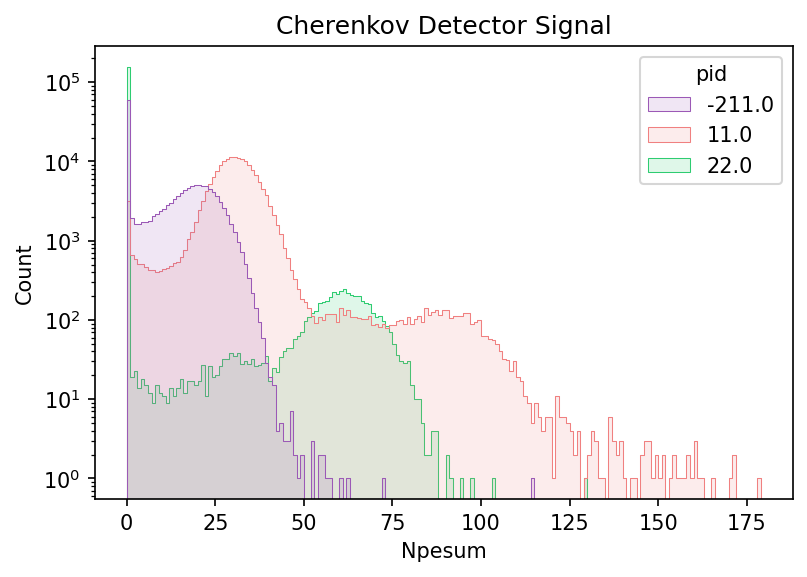

In [4]:
plt.figure(dpi=150)
plt.title("Cherenkov Detector Signal")
sns.histplot(sim_df, x="Npesum", hue="pid", element="step", binwidth=1, #weights="# rate",
             palette=sns.color_palette(best_colors[:-5]), alpha=0.15, linewidth=0.5)

#plt.vlines(20, 1, 10**4)

plt.yscale("log")

## Get Samples

In [6]:
#Show columns of interest
sim_df.columns[[15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]]

Index(['PreShSum', 'PreSh_l', 'PreSh_r', 'PreSh_t', 'ShowerSum', 'Shower_l',
       'Shower_r', 'Shower_t', 'SC_A_Eendsum', 'SC_D_Eendsum', 'SC_C_Eendsum',
       'SC_B_Eendsum', 'LASPD_Eendsum', 'GEM00_n', 'GEM10_n', 'GEM01_n',
       'GEM11_n', 'Npesum', 'theta'],
      dtype='object')

In [8]:
%%time

#Only charged particles 
keeps = (sim_df["pid"]==11) | (sim_df["pid"]==-211)

#Select the charged particles and convert the df into a np array
data_np = (sim_df[keeps]).to_numpy()

#Select only columns of interest for classification
Full_X = data_np[:,[15,16,17,18, 19,20,21,22, 24,27,30,33, 39, 41,47,53,59, -2,-1]] #Baseline

#Get event PID labels
y = data_np[:,8].astype(int)
#Set labels to 0 & 1
y[y==11] = 0
y[y==-211] = 1

#Scale variables between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(Full_X)

train_data, test_data, train_labels, test_labels = train_test_split(scaled_data, y, test_size=0.4, random_state=42)

print("Train:", len(train_data))
print("Test:", len(test_data))

Train: 202791
Test: 135195
CPU times: user 159 ms, sys: 117 ms, total: 275 ms
Wall time: 273 ms


In [9]:
#Show num of each pid & check labels are set properly
np.unique(y,return_counts=1)

(array([0, 1]), array([182035, 155951]))

## Define MLP Model
***
Here, I define the MLP model with 7 hideden layers as well as BatchNormalization and Dropout between hidden layers. 

In [13]:
model = tf.keras.Sequential([
    Input(scaled_data.shape[-1]), #Define input size from dimensions of data array
    Dense(512, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(256, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(128, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(64, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(32, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(16, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(8, activation="relu"), BatchNormalization(), Dropout(0.15),
    Dense(len(np.unique(y)), activation="softmax") #Softmax for output
])

#Give model summary
model.summary()

#Define Adam optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

#Compile model to be used for training
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               10240     
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

## Training

In [14]:
%%time

version = "Pencil_TestModel"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=.01, factor=0.9, patience=3, min_lr=1e-5) #Reduce training rate on plateau
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=6) #Early stopping 

history = model.fit(train_data[:,1:], train_labels, 
                    batch_size=3000, epochs=100, #Can adjust parameters to achieve optimal training
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(test_data, test_labels))


Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:787 train_step
        y_pred = self(x, training=True)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 19 but received input with shape (None, 18)


In [66]:
%%time

#Note: You need a subdirectory named "Models"

##Save Model
tf.keras.models.save_model(model,f"Models/{version}/Model")
model.save_weights(f"Models/{version}/Weights")
 
# load model
tf.keras.models.load_model(f"Models/{version}/Model").summary()
savedModel = model.load_weights(f"Models/{version}/Weights")

INFO:tensorflow:Assets written to: Models/SULI_Week5_Pencil_ECal/Model/assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               4608      
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
__________________________________________

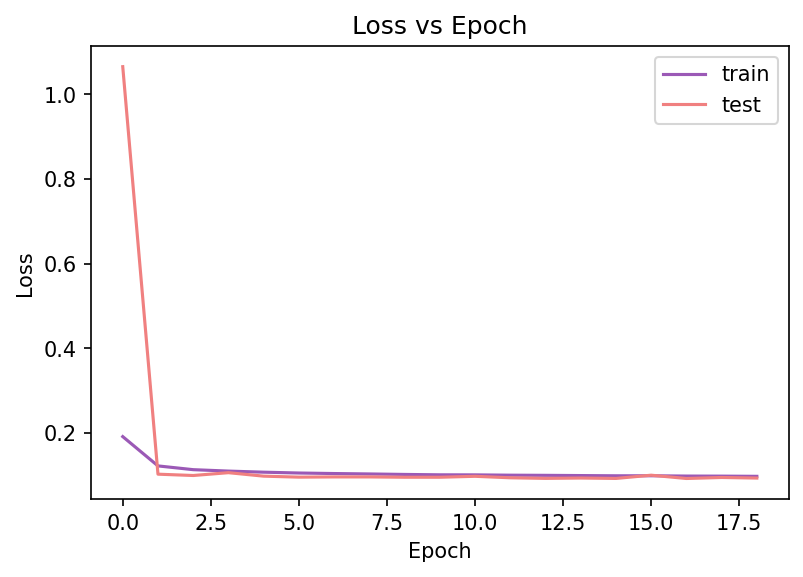

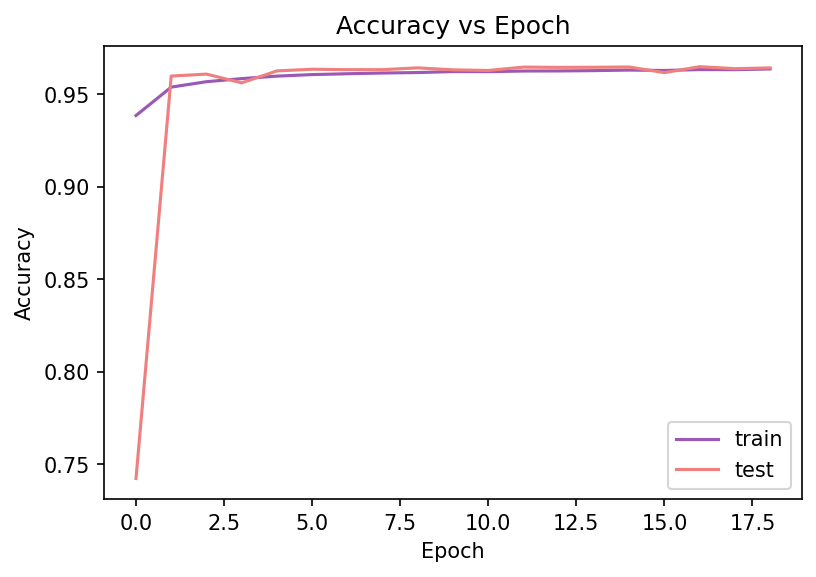

In [67]:
#Note: You need a subdirectory named "Plots"

plt.figure(dpi=150)
plt.title("Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["loss"])),history.history["loss"], label="train")
plt.plot(np.arange(len(history.history["val_loss"])),history.history["val_loss"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Loss_{version}.pdf")
plt.show()

plt.figure(dpi=150)
plt.title("Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"], label="train")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label="test")
plt.legend()
plt.savefig(f"Plots/Sim_Accuracy_{version}.pdf")
plt.show()

## Confusion Matrix

CPU times: user 1min 17s, sys: 10.6 s, total: 1min 27s
Wall time: 33.8 s


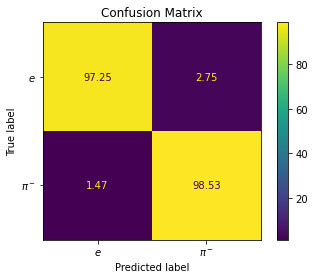

In [33]:
%%time

predictions = model.predict(test_data)
results = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels,results)
cm_percent = (cm)/(np.repeat(cm.sum(axis=1),2,axis=0).reshape(2,2))*100
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent,display_labels=["$e$","$\pi^-$"])
disp.plot(values_format='.2f')

plt.title(f"Confusion Matrix")

plt.savefig(f"Plots/Sim_Confusion_{version}.pdf")

